In [3]:
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import random_split
from torch import nn
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from fastprogress.fastprogress import master_bar, progress_bar

/home/jonny/projects/sudoku_solver/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
file_name = "sudoku_4m_easy_to_hard"

if 'quizzes' not in globals() or 'solutions' not in globals():
    try:
        quizzes = np.load(f"./data/{file_name}.npz")["quizzes"]
        solutions = np.load(f"./data/{file_name}.npz")["solutions"]
    except FileNotFoundError:
        quizzes = np.zeros((4000000, 81), np.int32)
        solutions = np.zeros((4000000, 81), np.int32)
        for i, line in enumerate(tqdm(open(f'./data/{file_name}.csv', 'r').read().splitlines()[1:])):
            quiz, solution, _ = line.split(",")
            for j, q_s in enumerate(zip(quiz, solution)):
                q, s = q_s
                quizzes[i, j] = q
                solutions[i, j] = s
        np.savez(f"./data/{file_name}.npz", quizzes=quizzes, solutions=solutions)

In [5]:
class CustomSudokuDataset(Dataset):
    def __init__(self, quizzes, solutions, transform=None, target_transform=None):
        self.quizzes = torch.from_numpy(quizzes).to(torch.int64)
        self.solutions = torch.from_numpy(solutions).to(torch.int64)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.quizzes)

    def __getitem__(self, idx):
        quiz = self.quizzes[idx]
        solution = self.solutions[idx]
        if self.transform:
            quiz = self.transform(quiz)
        if self.target_transform:
            solution = self.target_transform(solution)
        return quiz.type(torch.float).to("cuda"), solution.type(torch.long).to("cuda")

In [6]:
def one_hot_options(input_tensor):
    return F.one_hot(input_tensor, 10)[:,1:]

In [7]:
dataset = CustomSudokuDataset(quizzes, solutions, one_hot_options)

In [8]:
generator = torch.Generator().manual_seed(42)
training_data, test_data = random_split(dataset, [0.8, 0.2], generator=generator)

In [9]:
batch_size = 64

In [10]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer, mb, epoch_no=1, graphs=None):
    size = len(dataloader.dataset)
    losses = []
    item_count = []
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(progress_bar(dataloader, parent=mb)):
        mb.child.comment = "Training loop"
        # Compute prediction and loss
        preds = model(X)
        loss = loss_fn(X, y, preds)[0]

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            losses.append(loss)
            item_count.append(current)
            
            graphs[epoch_no - 1]=[item_count, losses]
            
            
            np_graphs = np.array(graphs[epoch_no - 1])[1]
            
            if epoch_no > 1:
                prev_epoch_np_graphs = np.array(graphs[:epoch_no - 1])[:,1]
                np_graphs = np.concatenate((np_graphs, prev_epoch_np_graphs.flatten()))
                
            upper_bound = np_graphs.max()
            lower_bound = np_graphs.min()
            padding = 0.02
            
            mb.update_graph(graphs, [0, size], [lower_bound-padding, upper_bound+padding])


def test_loop(dataloader, model, loss_fn, mb=None, epoch_no=1):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss, total_correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in progress_bar(dataloader, parent=mb):
            if mb is not None:
                mb.child.comment = "Validation loop"
            preds = model(X)
            loss, correct = loss_fn(X, y, preds)
            total_loss += loss.item()
            total_correct += correct.item()

        total_loss /= num_batches
        total_correct /= size*81
        if mb is not None:
            mb.write(f"Epoch {epoch_no} Test Error: \n Accuracy: {(100*total_correct):>0.1f}%, Avg loss: {total_loss:>8f}")
        else:
            print(f"Epoch {epoch_no} Test Error: \n Accuracy: {(100*total_correct):>0.1f}%, Avg loss: {total_loss:>8f}")

# Loss Functions

Expected to return a tuple in the format `(loss, num_correct)`

In [12]:
def loss_replace_known_values(X, y, preds):
    loss_fn = nn.CrossEntropyLoss()

    # replace known values with their correct alternatives
    mask = (X.max(2).values == 0).type(torch.int).unsqueeze(2)
    y2 = F.one_hot(y, 10)[:,:,1:]
    preds = ((y2 * (1-mask)) + preds*mask)
    
    # remove values already known 
    missing_idx = (mask[0].squeeze() == 1).nonzero(as_tuple=True)[0]
    preds = preds[:, (missing_idx), :]
    y = y[:, (missing_idx)]
    
    pred_split = preds.permute(0, 2, 1)
    # returns loss, # correct
    loss = loss_fn(pred_split, y-1)
    num_correct = (pred_split.argmax(1) == y-1).type(torch.int).sum()
    return loss, num_correct

In [13]:
def loss_compare_all_numbers(X, y, preds):
    loss_fn = nn.CrossEntropyLoss()

    # Cross Entropy Loss required the Batch Size, then classes (numbers 1-9 in our case), then the dimensions inputs for each batch (shape 81)
    pred_split = preds.permute(0, 2, 1)

    loss = loss_fn(pred_split, y-1)
    num_correct = (pred_split.argmax(1) == y-1).type(torch.int).sum()

    return loss, num_correct

In [14]:
def compare_tensors(tensor1, tensor2):
    result_tensor = torch.zeros_like(tensor1, dtype=torch.float32)
    result_tensor[tensor1 == tensor2] = 1
    return result_tensor

def loss_remove_wrong_answers(X, y, preds):
    loss_fn = nn.CrossEntropyLoss()

    # replace known values with their correct alternatives
    mask = (X.max(2).values == 0).type(torch.int).unsqueeze(2)
    y2 = F.one_hot(y, 10)[:,:,1:]
    preds = ((y2 * (1-mask)) + preds*mask)

    second_mask = compare_tensors(y2, preds)
    preds = preds * second_mask

    # remove values already known 
    missing_idx = (mask[0].squeeze() == 1).nonzero(as_tuple=True)[0]
    preds = preds[:, (missing_idx), :]
    y = y[:, (missing_idx)]

    pred_split = preds.permute(0, 2, 1)
    # returns loss, # correct
    loss = loss_fn(pred_split, y-1)
    num_correct = (pred_split.argmax(1) == y-1).type(torch.int).sum()
    return loss, num_correct

# Baseline scoring

We're going to create a model which just returns random numbers. This gives us an idea of what the baseline accuracy is. Anything above this level is the model starting to make _some_ correct predictions.

In [15]:
class base_model:
    def __call__(self, x):
        # generate random numbers for all of the cells
        rand_preds = (torch.rand_like(x)*8) + 1
        
        return rand_preds
    
    def eval(self):
        pass

In [16]:
# test_loop(test_dataloader, base_model(), loss_compare_all_numbers)

In [17]:
# test_loop(test_dataloader, base_model(), loss_replace_known_values)

We can see that this model has 48.2% accuracy when just returning the initial values. This means that any model which does about this well may simply be learning to return the input results. 

Our input is the numbers 1-9 (one-hot encoded) so if we wrote some code which simply returned the input values and also randomly guessed a number between these values, then we'd get `41.7 + (100-41.7)*0.111 = 48.17%` accuracy. This means for our model to be truly starting to correctly predict it must be above this baseline accuracy.

# Models

In [18]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(1, (81, 9))
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(729, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 729),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return self.unflatten(logits)

In [19]:
class CNNBase(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(9, 81, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
            nn.Conv2d(81, 729, kernel_size=3, stride=3), # 1x1
        )

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))
        logits = self.linear_relu_stack(mod_x)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

In [20]:
class CNNBaseNorm(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(9, 81, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
            nn.BatchNorm2d(81),
            nn.Conv2d(81, 729, kernel_size=3, stride=3), # 1x1
        )

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))
        logits = self.linear_relu_stack(mod_x)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

In [21]:
class CNNStrideOne(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(9, 9, kernel_size=3, stride=1), # 9x9
            nn.ReLU(),
            nn.Conv2d(9, 81, kernel_size=3, stride=1), # 3x3
            nn.ReLU(),
            nn.Conv2d(81, 729, kernel_size=3, stride=1), # 1x1
        )

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))
        logits = self.linear_relu_stack(mod_x)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

In [22]:
class CNNLinear(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(9, 81, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
            nn.Conv2d(81, 81, kernel_size=3, stride=3), # 1x1
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(81, 729),
#             nn.ReLU(),
#             nn.Conv2d(81, 729, kernel_size=3),
        )

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))
        logits = self.linear_relu_stack(mod_x)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

In [23]:
class CNNCombi(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.three_by_three = nn.Sequential(
            nn.Conv2d(9, 81, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
            nn.Conv2d(81, 81, kernel_size=3, stride=3), # 1x1
            nn.ReLU(),
        )
        
        self.one_by_nine = nn.Sequential(
            nn.Conv2d(9, 81, kernel_size=(1,9), stride=1), # 9x1
            nn.ReLU(),
        )
        
        self.nine_by_one = nn.Sequential(
            nn.Conv2d(9, 81, kernel_size=(9,1), stride=1), # 1x9
            nn.ReLU(),
        )
        
        self.linear = nn.Sequential(
            nn.Linear(1539, 100),
            nn.ReLU(),
            nn.Linear(100, 729),
        )
        

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))
        conv1 = self.three_by_three(mod_x).squeeze(3)
        conv2 = self.one_by_nine(mod_x).squeeze()
        conv3 = self.nine_by_one(mod_x).squeeze()
        conv_concat = torch.cat((conv1, conv2, conv3), dim=2)
        conv_concat = conv_concat.flatten(1,2)
        logits = self.linear(conv_concat)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

In [24]:
class CNNCombiNorm(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.three_by_three = nn.Sequential(
            nn.Conv2d(9, 81, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
            nn.BatchNorm2d(81),
        )
        
        self.one_by_nine = nn.Sequential(
            nn.Conv2d(9, 81, kernel_size=(1,9), stride=1), # 9x1
            nn.ReLU(),
            nn.BatchNorm2d(81),
        )
        
        self.nine_by_one = nn.Sequential(
            nn.Conv2d(9, 81, kernel_size=(9,1), stride=1), # 1x9
            nn.ReLU(),
            nn.BatchNorm2d(81),
        )
        
        self.linear = nn.Sequential(
            nn.Linear(2187, 729),
            nn.ReLU(),
            nn.BatchNorm1d(729),
            nn.Linear(729, 729),
        )
        

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))
        conv1 = self.three_by_three(mod_x).flatten(2)
        conv2 = self.one_by_nine(mod_x).squeeze()
        conv3 = self.nine_by_one(mod_x).squeeze()
        conv_concat = torch.cat((conv1, conv2, conv3), dim=2)
        conv_concat = conv_concat.flatten(1)
        logits = self.linear(conv_concat)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

In [25]:
class CNNCombiNormLarge(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.three_by_three = nn.Sequential(
            nn.Conv2d(9, 81, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
            nn.BatchNorm2d(81),
        )
        
        self.one_by_nine = nn.Sequential(
            nn.Conv2d(9, 81, kernel_size=(1,9), stride=1), # 9x1
            nn.ReLU(),
            nn.BatchNorm2d(81),
        )
        
        self.nine_by_one = nn.Sequential(
            nn.Conv2d(9, 81, kernel_size=(9,1), stride=1), # 1x9
            nn.ReLU(),
            nn.BatchNorm2d(81),
        )
        
        self.linear = nn.Sequential(
            nn.Linear(2187, 2000),
            nn.ReLU(),
            nn.BatchNorm1d(2000),
            nn.Linear(2000, 2000),
            nn.ReLU(),
            nn.BatchNorm1d(2000),
            nn.Linear(2000, 729),
            nn.ReLU(),
            nn.BatchNorm1d(729),
            nn.Linear(729, 729),
        )
        

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))
        conv1 = self.three_by_three(mod_x).flatten(2)
        conv2 = self.one_by_nine(mod_x).squeeze()
        conv3 = self.nine_by_one(mod_x).squeeze()
        conv_concat = torch.cat((conv1, conv2, conv3), dim=2)
        conv_concat = conv_concat.flatten(1)
        logits = self.linear(conv_concat)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

In [30]:
class CNNCombiNormXL(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.three_by_three = nn.Sequential(
            nn.Conv2d(9, 729, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
            nn.BatchNorm2d(729),
        )
        
        self.one_by_nine = nn.Sequential(
            nn.Conv2d(9, 729, kernel_size=(1,9), stride=1), # 9x1
            nn.ReLU(),
            nn.BatchNorm2d(729),
        )
        
        self.nine_by_one = nn.Sequential(
            nn.Conv2d(9, 729, kernel_size=(9,1), stride=1), # 1x9
            nn.ReLU(),
            nn.BatchNorm2d(729),
        )
        
        self.linear = nn.Sequential(
            nn.Linear(19683, 2000),
            nn.ReLU(),
            nn.BatchNorm1d(2000),
            nn.Linear(2000, 729),
        )
        

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))
        conv1 = self.three_by_three(mod_x).flatten(2)
        conv2 = self.one_by_nine(mod_x).squeeze()
        conv3 = self.nine_by_one(mod_x).squeeze()
        conv_concat = torch.cat((conv1, conv2, conv3), dim=2)
        conv_concat = conv_concat.flatten(1)
        logits = self.linear(conv_concat)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

In [27]:
class CNNCombiNormSmall(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.three_by_three = nn.Sequential(
            nn.Conv2d(9, 9, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
            nn.BatchNorm2d(9),
        )
        
        self.one_by_nine = nn.Sequential(
            nn.Conv2d(9, 9, kernel_size=(1,9), stride=1), # 9x1
            nn.ReLU(),
            nn.BatchNorm2d(9),
        )
        
        self.nine_by_one = nn.Sequential(
            nn.Conv2d(9, 9, kernel_size=(9,1), stride=1), # 1x9
            nn.ReLU(),
            nn.BatchNorm2d(9),
        )
        
        self.linear = nn.Sequential(
            nn.Linear(243, 729),
        )
        

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))
        conv1 = self.three_by_three(mod_x).squeeze().flatten(1)
        conv2 = self.one_by_nine(mod_x).squeeze().flatten(1)
        conv3 = self.nine_by_one(mod_x).squeeze().flatten(1)
        conv_concat = torch.cat((conv1, conv2, conv3), dim=1)
        logits = self.linear(conv_concat)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

# Learning Rates

In [37]:
def lr_finder(training_data, model_class, loss_fn, initial_lr=1e-4, saved_weights_path=None):
    dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    
    min_loss = 1000
    learning_rate = initial_lr
    lrs = []
    losses = []
    local_min = 1000
    
    model = model_class().to("cuda")
    if saved_weights_path:
        model.load_state_dict(torch.load(saved_weights_path))

    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()

    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        preds = model(X)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

        loss = loss_fn(X, y, preds)[0]
            
        if loss < local_min:
            local_min = loss.item()
        if loss < min_loss:
            min_loss = loss
        elif loss > min_loss * 3:
            break

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 50 == 0:
            losses.append(local_min)
            lrs.append(learning_rate)
            learning_rate*=1.3
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
            local_min = 1000


        
    plt.plot(lrs, losses)
    plt.xscale('log')
        
        

In [38]:
lr_finder(training_data, CNNCombiNormXL, loss_compare_all_numbers, initial_lr=1e-6)

TypeError: 'DataLoader' object is not subscriptable

# Training

In [35]:
def train_model(model, epochs=5, learning_rate=0.01, learning_rate_decay=0.8, loss_function=loss_replace_known_values, shuffle_after_first_epoch=False, training_data=training_data, test_data=test_data):
    graphs = [[] for _ in range(epochs)]
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=not shuffle_after_first_epoch)

    mb = master_bar(range(1, epochs+1))
    mb.names = [f"Epoch {i+1}" for i in range(epochs)]
    mb.main_bar.comment = "Epochs"

    for t in mb:
        if shuffle_after_first_epoch and t == 2:
            train_dataloader =  DataLoader(training_data, batch_size=batch_size, shuffle=True)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
        train_loop(train_dataloader, model, loss_function, optimizer, mb, t, graphs)
        test_loop(test_dataloader, model, loss_function, mb, t)
        learning_rate = learning_rate * learning_rate_decay

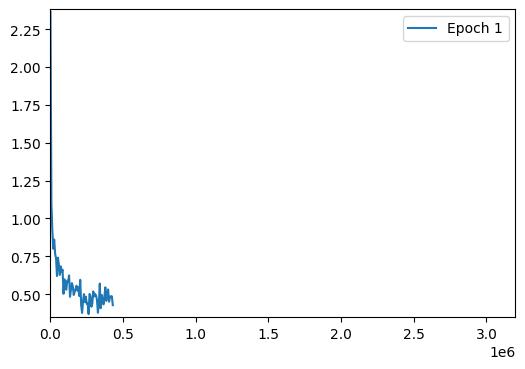

KeyboardInterrupt: 

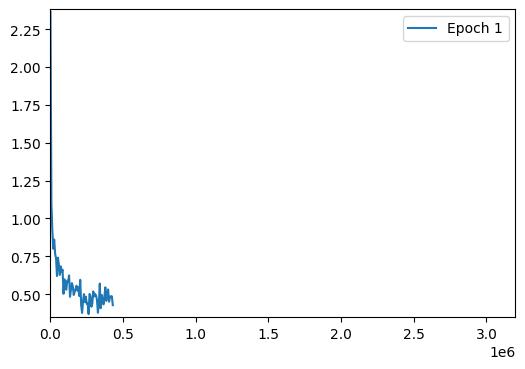

In [36]:
model = CNNCombiNormXL().to("cuda")
# model.load_state_dict(torch.load("./models/CNNCombiNorm.model"))
train_model(model, learning_rate=1e-4, epochs=5, loss_function=loss_compare_all_numbers, shuffle_after_first_epoch=True)

In [ ]:
torch.save(model.state_dict(), f"./models/{model.__class__.__name__}.model")

In [ ]:
def has_duplicates_in_rows(tensor):
    for row in tensor:
         if row.bincount()[1:].max() > 1:
             return True
    return False

def check_valid_2(sol):
    sol = sol.reshape(9,9)
    # rows
    if has_duplicates_in_rows(sol):
        return False
    
    # cols
    cols = sol.permute(1,0)
    if has_duplicates_in_rows(cols):
        return False
    
    grids = sol.unfold(0,3,3).flatten(0).split(9)
    if has_duplicates_in_rows(grids):
        return False

    return True

def answer_loop(model, mb=None):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()

    dataloader = DataLoader(test_data, batch_size=64, shuffle=False)
    size = len(dataloader.dataset)
    total_loss, total_numbers_correct, total_puzzles_correct = 0, 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in progress_bar(dataloader, parent=mb):
            if mb is not None:
                mb.child.comment = "Final test loop"
            
            # remove predictions for values already known
            mask = (X.max(2).values == 0).type(torch.int).unsqueeze(2)
            X_update = X.clone()

            while mask.sum() > 0:
                preds = model(X_update)
                
                mask = (X_update.max(2).values == 0).type(torch.float).unsqueeze(2)
                
                preds_updated = preds + (torch.nan_to_num((mask-1)*float("Inf")))

                # get indicies of values that the model is most certain about for each batch
                # this is the idx of batches which still have values to fill out
                idx = mask.nonzero(as_tuple=True)[0].unique()
                certain_idx = preds_updated.flatten(1).argmax(1) # shape = [64]
                certain_cells = certain_idx // 9

                certain_numbers = preds_updated[idx, certain_cells[idx]].argmax(1) + 1
                certain_numbers_one_hot = F.one_hot(certain_numbers, 10)[:,1:]
                
                # replace the most certiain numbers in X
                X_update[idx, certain_cells[idx]] = certain_numbers_one_hot.type(torch.float)
            
            correct = loss_compare_all_numbers(X, y, X_update)[1]
            total_numbers_correct += correct.item()
            for i, puzzle_output in enumerate(X_update):
                solution = puzzle_output.argmax(1) + 1
                if check_valid_2(solution):
                    total_puzzles_correct += 1
                    print(total_puzzles_correct)

        total_puzzles_correct /= size
        total_numbers_correct /= size*81
        if mb is not None:
            mb.write(f"Final Test: \n Numbers Correct: {(100*total_numbers_correct):>0.1f}%, Puzzles Correct: {(100*total_puzzles_correct):>0.1f}%")
        else:
            print(f"Final Test: \n Numbers Correct: {(100*total_numbers_correct):>0.1f}%, Puzzles Correct: {(100*total_puzzles_correct):>0.1f}%")

In [ ]:
model = CNNCombiNormLarge().to("cuda")
model.load_state_dict(torch.load("./models/CNNCombiNormLarge.model"))

In [ ]:
answer_loop(model)
